In [67]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from monai.losses import DiceLoss
import monai
from tqdm import tqdm
import matplotlib.pyplot as plt

In [68]:

#print(monai.__version__)  # Should be ≥0.9.1
device = "cuda" if torch.cuda.is_available() else "cpu"

In [69]:
DATA_ROOT = "F:/Machine learning/PASCAL VOC/VOC2012_train_val"
BATCH_SIZE = 8
EPOCHS = 50
LR = 1e-4
IMG_SIZE = (256, 256)
SPLIT_RATIO = [0.8, 0.2]  # Train/Val ratio
TEST_RATIO = 0.2  # From val set
NUM_CLASSES = 21  # PASCAL VOC has 20 classes + background
single_image_path = os.path.join(DATA_ROOT, "2007_000033.jpg")
single_mask_path  = os.path.join(DATA_ROOT, "2007_000033.png")

In [70]:
class SingleImageDataset(Dataset):
    def __init__(self, image_path, mask_path, image_transform=None, mask_transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return 1  # Single image dataset

    def __getitem__(self, idx):
        image = Image.open(self.image_path).convert("RGB")
        mask = Image.open(self.mask_path)
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            # To convert the mask to tensor and add channel dimension.
            mask = torch.from_numpy(np.array(mask, dtype=np.int64))
            if mask.ndim == 2:
                mask = mask.unsqueeze(0)
        return image, mask

In [71]:
IMG_SIZE = (256, 256)

# Transform for the image (with normalization)
image_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transform for the mask: convert to grayscale (or 'L' mode), resize with NEAREST,
# then convert to tensor and add a channel dimension.
def mask_transform_fn(mask):
    mask = mask.convert('L')
    mask = transforms.Resize(IMG_SIZE, interpolation=Image.NEAREST)(mask)
    mask_np = np.array(mask, dtype=np.int64)
    # Remap any invalid labels to 0.
    mask_np[mask_np == 255] = 0
    mask_np[mask_np > NUM_CLASSES- 1] = 0
    return torch.from_numpy(mask_np).unsqueeze(0)
single_dataset = SingleImageDataset(
    image_path=single_image_path,
    mask_path=single_mask_path,
    image_transform=image_transform,
    mask_transform=mask_transform_fn
)

In [72]:
single_loader = DataLoader(single_dataset, batch_size=1, shuffle=False, pin_memory=True)


In [73]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        # Resize g to match x's spatial dimensions
        if g.shape[2:] != x.shape[2:]:
            g = F.interpolate(g, size=x.shape[2:], mode='bilinear', align_corners=False)
            
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [74]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

In [75]:
class UNetAttention(nn.Module):
    def __init__(self, in_channels=3, out_channels=NUM_CLASSES):
        super().__init__()
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Decoder with Attention
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attn4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = DoubleConv(1024, 512)  # 512 (upconv) + 512 (enc4)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attn3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = DoubleConv(512, 256)  # 256 (upconv) + 256 (enc3)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attn2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = DoubleConv(256, 128)  # 128 (upconv) + 128 (enc2)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attn1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec1 = DoubleConv(128, 64)  # 64 (upconv) + 64 (enc1)
        
        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)        # [B, 64, 256, 256]
        p1 = self.pool1(e1)      # [B, 64, 128, 128]
        
        e2 = self.enc2(p1)       # [B, 128, 128, 128]
        p2 = self.pool2(e2)      # [B, 128, 64, 64]
        
        e3 = self.enc3(p2)       # [B, 256, 64, 64]
        p3 = self.pool3(e3)      # [B, 256, 32, 32]
        
        e4 = self.enc4(p3)       # [B, 512, 32, 32]
        p4 = self.pool4(e4)      # [B, 512, 16, 16]
        
        # Bottleneck
        bn = self.bottleneck(p4) # [B, 1024, 16, 16]
        
        # Decoder
        d4 = self.upconv4(bn)    # [B, 512, 32, 32]
        a4 = self.attn4(g=d4, x=e4)  # [B, 512, 32, 32]
        d4 = torch.cat((a4, d4), dim=1)  # [B, 1024, 32, 32]
        d4 = self.dec4(d4)       # [B, 512, 32, 32]
        
        d3 = self.upconv3(d4)    # [B, 256, 64, 64]
        a3 = self.attn3(g=d3, x=e3)  # [B, 256, 64, 64]
        d3 = torch.cat((a3, d3), dim=1)  # [B, 512, 64, 64]
        d3 = self.dec3(d3)       # [B, 256, 64, 64]
        
        d2 = self.upconv2(d3)    # [B, 128, 128, 128]
        a2 = self.attn2(g=d2, x=e2)  # [B, 128, 128, 128]
        d2 = torch.cat((a2, d2), dim=1)  # [B, 256, 128, 128]
        d2 = self.dec2(d2)       # [B, 128, 128, 128]
        
        d1 = self.upconv1(d2)    # [B, 64, 256, 256]
        a1 = self.attn1(g=d1, x=e1)  # [B, 64, 256, 256]
        d1 = torch.cat((a1, d1), dim=1)  # [B, 128, 256, 256]
        d1 = self.dec1(d1)       # [B, 64, 256, 256]
        
        return self.final(d1)    # [B, NUM_CLASSES, 256, 256]

In [76]:
#class DiceLoss(nn.Module):
    #def __init__(self, smooth=1e-6):
        #super(DiceLoss, self).__init__()
       # self.smooth = smooth

    #def forward(self, logits, targets):
       # probs = torch.softmax(logits, dim=1)
        #num = targets.size(0)
       # m1 = probs.view(num, -1)
       # m2 = targets.view(num, -1)
        #intersection = (m1 * m2).sum(1)
        #dice = (2. * intersection + self.smooth) / (m1.sum(1) + m2.sum(1) + self.smooth)
        #return 1 - dice.mean()

In [77]:
def calculate_metrics(preds, targets):
    # Convert to class indices
    preds = torch.argmax(preds, dim=1)
    targets = targets.long()
    
    iou_per_class = []
    dice_per_class = []
    
    for cls in range(NUM_CLASSES):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        
        iou = (intersection + 1e-6) / (union + 1e-6)
        dice = (2 * intersection + 1e-6) / (pred_inds.sum() + target_inds.sum() + 1e-6)
        
        iou_per_class.append(iou)
        dice_per_class.append(dice)
    
    return torch.mean(torch.stack(iou_per_class)), torch.mean(torch.stack(dice_per_class))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetAttention().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

ce_loss = nn.CrossEntropyLoss()
dice_loss = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=True,
    softmax=True,
    reduction="mean"
)


Training Epochs:  20%|██        | 2/10 [00:00<00:00, 14.28it/s]

Epoch 1/10, Total Loss: 3.9307, CE: 2.9358, Dice: 0.9949
Epoch 2/10, Total Loss: 3.8696, CE: 2.8750, Dice: 0.9946
Epoch 3/10, Total Loss: 3.8210, CE: 2.8266, Dice: 0.9943


Training Epochs:  60%|██████    | 6/10 [00:00<00:00, 14.73it/s]

Epoch 4/10, Total Loss: 3.7784, CE: 2.7842, Dice: 0.9941
Epoch 5/10, Total Loss: 3.7401, CE: 2.7462, Dice: 0.9939
Epoch 6/10, Total Loss: 3.7049, CE: 2.7113, Dice: 0.9937


Training Epochs:  80%|████████  | 8/10 [00:00<00:00, 14.96it/s]

Epoch 7/10, Total Loss: 3.6719, CE: 2.6784, Dice: 0.9935
Epoch 8/10, Total Loss: 3.6400, CE: 2.6467, Dice: 0.9932
Epoch 9/10, Total Loss: 3.6088, CE: 2.6158, Dice: 0.9930


Training Epochs: 100%|██████████| 10/10 [00:00<00:00, 14.87it/s]

Epoch 10/10, Total Loss: 3.5782, CE: 2.5853, Dice: 0.9928


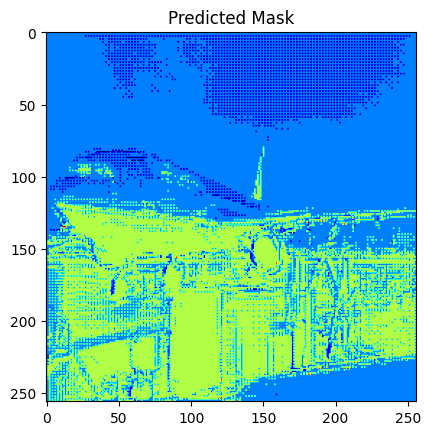

In [78]:
EPOCHS = 10 
dice_loss_history = []
ce_loss_history = []
total_loss_history = []


for epoch in tqdm(range(EPOCHS), desc="Training Epochs", total=EPOCHS):
    model.train()
    epoch_dice_loss = 0.0
    epoch_ce_loss = 0.0
    epoch_total_loss = 0.0
    
    for images, masks in single_loader:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        # To Ensure masks have a channel dimension for DiceLoss
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)  # Expected shape= [N, NUM_CLASSES, H, W]
        
        ce = ce_loss(outputs, masks.squeeze(1))  # targets shape= [N, H, W]
        dice = dice_loss(outputs, masks)      # shape= [N, 1, H, W]
        loss = ce + dice
        loss.backward()
        optimizer.step()
        
        epoch_ce_loss += ce.item()
        epoch_dice_loss += dice.item()
        epoch_total_loss += loss.item()
    
    avg_ce_loss = epoch_ce_loss / len(single_loader)
    avg_dice_loss = epoch_dice_loss / len(single_loader)
    avg_total_loss = epoch_total_loss / len(single_loader)
    
    ce_loss_history.append(avg_ce_loss)
    dice_loss_history.append(avg_dice_loss)
    total_loss_history.append(avg_total_loss)
    
    tqdm.write(f"Epoch {epoch+1}/{EPOCHS}, Total Loss: {avg_total_loss:.4f}, CE: {avg_ce_loss:.4f}, Dice: {avg_dice_loss:.4f}")

# For inference:
model.eval()
with torch.no_grad():
    for images, masks in single_loader:
        images = images.to(device)
        outputs = model(images)
        # Convert model output to predicted mask: [N, H, W]
        pred_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()
        plt.imshow(pred_mask, cmap='jet')
        plt.title("Predicted Mask")
        plt.show()



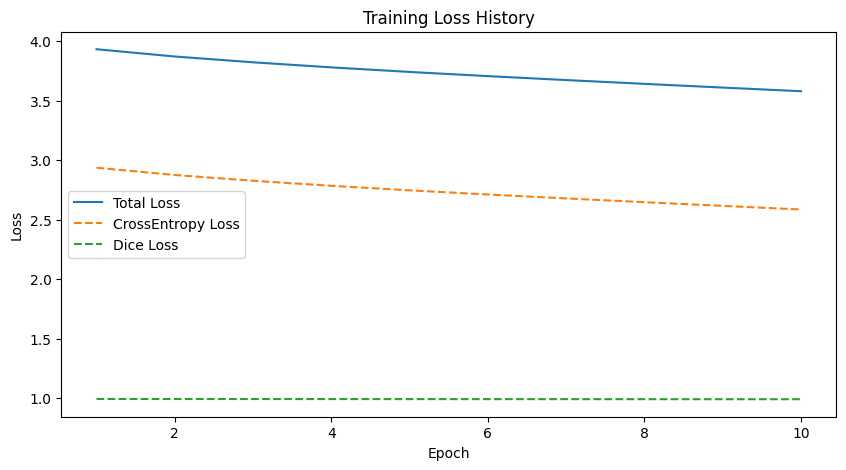

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), total_loss_history, label='Total Loss')
plt.plot(range(1, EPOCHS+1), ce_loss_history, label='CrossEntropy Loss', linestyle='--')
plt.plot(range(1, EPOCHS+1), dice_loss_history, label='Dice Loss', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()